## QISKIT

In [241]:
from qiskit import QuantumCircuit, transpile, assemble
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np

In [242]:
def initialize_superposition(qc, qubits):
    for qubit in qubits:
        qc.h(qubit)
    qc.barrier()

In [243]:
def simple_sum(qc, qub_sum, ancillas):
    for idx, comb in enumerate(qub_sum):
        qc.cx(comb[0], ancillas[idx])
        qc.cx(comb[1], ancillas[idx])
        qc.barrier()

In [244]:
def diagonal_constraints(qc, qub_diag, ancillas, previous_constraint_length):
    for idx, comb in enumerate(qub_diag):
        qc.x(ancillas[idx + previous_constraint_length])
        qc.ccx(comb[0], comb[1], ancillas[idx + previous_constraint_length])
        # qc.cx(comb[0], ancillas[idx + previous_constraint_length])
        # qc.cx(comb[1], ancillas[idx + previous_constraint_length])
        qc.barrier()

In [245]:
def multi_qubit_sum(qc, qub_multi, ancillas, previous_constraint_length):
    for idx, comb in enumerate(qub_multi):
        qc.cx(comb[0], ancillas[idx + previous_constraint_length])
        qc.cx(comb[1], ancillas[idx + previous_constraint_length])
        qc.cx(comb[2], ancillas[idx + previous_constraint_length])

        qc.ccx(comb[0], comb[1], ancillas[idx + previous_constraint_length + 1])
        qc.ccx(comb[2], ancillas[idx + previous_constraint_length + 1], ancillas[idx + previous_constraint_length])
        qc.ccx(comb[0], comb[1], ancillas[idx + previous_constraint_length + 1])

        # qc.mcx([comb[0], comb[1]], ancillas[idx + previous_constraint_length + 1])
        # qc.mcx([comb[2], ancillas[idx + previous_constraint_length + 1]], ancillas[idx + previous_constraint_length])
        # qc.mcx([comb[1], comb[2]], ancillas[idx + previous_constraint_length + 1])
        qc.barrier()

In [246]:
def check_all_one(qc, qubits, ancillas, previous_constraint_length):

    num_ancillas = len(ancillas)

    # Special condition: Include c0=1 equation (qubit[0] must be 1)
    # qc.mcx([qubits[0], ancillas[0]], ancillas[7])  # First step incorporating qubit[0]
    qc.ccx(qubits[0], ancillas[0], ancillas[7])

    for idx in range(1, 7):
        # qc.mcx([ancillas[idx], ancillas[idx + previous_constraint_length - 1]], ancillas[idx + previous_constraint_length])
        qc.ccx(ancillas[idx], ancillas[idx + previous_constraint_length - 1], ancillas[idx + previous_constraint_length])

    qc.cx(ancillas[6 + previous_constraint_length], ancillas[6 + previous_constraint_length + 1])

    for idx in reversed(range(1, 7)):
        # qc.mcx([ancillas[idx], ancillas[idx + previous_constraint_length -1]], ancillas[idx + previous_constraint_length])
        qc.ccx(ancillas[idx], ancillas[idx + previous_constraint_length -1], ancillas[idx + previous_constraint_length])

    # Uncompute the special c0=1 condition
    # qc.mcx([qubits[0], ancillas[0]], ancillas[7])
    qc.ccx(qubits[0], ancillas[0], ancillas[7])
    qc.barrier()

In [247]:
# def constraint_tree_check(qc, constraints, ancillas, phase_flip_target, uncompute=False):
#     if len(constraints) < 2:
#         raise ValueError("Need at least two constraints for tree reduction")

#     levels = []
#     current_level = constraints[:]
#     ancilla_idx = 0

#     while len(current_level) > 1:
#         next_level = []
#         for i in range(0, len(current_level) -1, 2):
#             a, b = current_level[i], current_level[i+1]
#             anc = ancillas[ancilla_idx]
#             qc.ccx(a, b, anc)
#             next_level.append(anc)
#             ancilla_idx += 1
#         if len(current_level) % 2 == 1:
#             next_level.append(current_level[-1])
#         levels.append((current_level, next_level))
#         current_level = next_level

#     if uncompute == False:
#         qc.cz(current_level[0], phase_flip_target)

#     for prev_level, next_level in reversed(levels):
#         for i in range(0, len(prev_level) -1, 2):
#             a, b = prev_level[i], prev_level[i + 1]
#             anc = next_level[i // 2]
#             qc.ccx(a, b, anc)

#     qc.barrier()

In [248]:
# def check_all_one_optimized(qc, qubits, constraint_ancillas, ancilla_a, ancilla_b, phase_flip_target=None, uncompute=False):
#     if len(constraint_ancillas) < 1:
#         raise ValueError("At last one constraint ancilla is required")

#     if not uncompute:
#         qc.ccx(qubits[0], constraint_ancillas[0], ancilla_a)

#         for idx in range(1, len(constraint_ancillas)):
#             qc.ccx(constraint_ancillas[idx], ancilla_a, ancilla_b)
#             qc.cx(ancilla_b, ancilla_a)
#             qc.ccx(constraint_ancillas[idx], ancilla_a, ancilla_b)

#         if phase_flip_target is not None:
#             # inst = qc.z(phase_flip_target)
#             # inst.c_if(qc.cregs[0], 1)
#             # qc.cz(ancilla_a, phase_flip_target)
            
#             # qc.cz(ancilla_a, phase_flip_target)
#             qc.z(ancilla_a)
            
#             # qc.cx(ancilla_a, phase_flip_target)
#             # qc.z(phase_flip_target)
#             # qc.cx(ancilla_a, phase_flip_target)

#         # qc.ccx(qubits[0], constraint_ancillas[0], ancilla_a)

#     else:
#         qc.ccx(qubits[0], constraint_ancillas[0], ancilla_a)
        
#         # for idx in reversed(range(1, len(constraint_ancillas))):
#         for idx in range(1, len(constraint_ancillas)):
#             qc.ccx(constraint_ancillas[idx], ancilla_a, ancilla_b)
#             qc.cx(ancilla_b, ancilla_a)
#             qc.ccx(constraint_ancillas[idx], ancilla_a, ancilla_b)

#         # qc.ccx(qubits[0], constraint_ancillas[0], ancilla_a)

#     qc.barrier()

In [249]:
def uncompute_check_all_one_optimized(qc, qubits, constraint_ancillas, ancilla_a, ancilla_b, phase_flip_target=None):
    qc.ccx(qubits[0], constraint_ancillas[0], ancilla_a)
    
    for idx in range(1, len(constraint_ancillas)):
        qc.ccx(constraint_ancillas[idx], ancilla_a, ancilla_b)
        qc.cx(ancilla_b, ancilla_a)
        qc.ccx(constraint_ancillas[idx], ancilla_a, ancilla_b)
        
    qc.barrier()

In [250]:
def grover_diff_optimized(qc, qubits, ancilla):
    qc.h(qubits)
    qc.x(qubits)

    qc.barrier()

    qc.h(qubits[-1])
    qc.mcx(qubits[:-1], qubits[-1])
    qc.h(qubits[-1])

    # qc.h(ancilla[-1])
    # qc.mcx([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5]], ancilla[-1])
    # qc.h(ancilla[-1])
    
    qc.barrier()

    qc.x(qubits)
    qc.h(qubits)
    qc.barrier()

In [251]:
def grover_diff(qc, qubits, ancillas, previous_constraint_length):

    # Step 1: Apply Hadamard and X gates (Inversion About Mean)
    qc.h(qubits)
    qc.x(qubits)
    qc.barrier()

    # Step 2: Construct MCZ using Toffoli-like AND computation with ancillas
    qc.ccx(qubits[0], qubits[1], ancillas[previous_constraint_length])

    # Forward Computation - Create Multi-Controlled Z
    aux = 2
    num_iterations = len(ancillas) - previous_constraint_length - 1  # Count valid ancilla indices

    for idx in range(num_iterations):
        # print(idx)
        qc.ccx(qubits[aux + idx], ancillas[previous_constraint_length + idx], ancillas[previous_constraint_length + idx + 1]) 


    qc.barrier()
    # Apply final Controlled-Z to flip phase
    qc.cz(qubits[-1], ancillas[-1])
    # qc.cz(qubits[-1], ancillas[-2])
    qc.barrier()

    # Step 3: Reverse Computation (Uncompute Ancilla Chain)
    for idx in reversed(range(num_iterations)):
        qc.ccx(qubits[aux + idx], ancillas[previous_constraint_length + idx], ancillas[previous_constraint_length + idx + 1])

    # Uncompute the first CCX gate
    qc.ccx(qubits[0], qubits[1], ancillas[previous_constraint_length])

    qc.barrier()

    # Step 4: Undo the Hadamard and X Gates
    qc.x(qubits)
    qc.h(qubits)
    qc.barrier()


In [252]:
# n_qubits = 6
# n_ancillas = 11
# tot_qubs = 17

# n_qubits = 6
# n_ancillas = 12
# tot_qubs = 18

# n_qubits = 6
# n_ancillas = 15
# tot_qubs = 20

n_qubits = 6
n_ancillas = 15
tot_qubs = 21



qub_simple_sum = [
    [0, 1],
    [2, 3],
    [4, 5],
    [2, 4],
]

qub_diag_sum = [
    [0, 2],
    [1, 2]
]

qub_multi_sum = [
    [1, 3, 5]
]


qubits = list(range(6))
# ancillas = list(range(n_qubits, n_ancillas + 1))
ancillas = list(range(n_qubits, tot_qubs))
tot_qubs = list(range(tot_qubs))


# circ = QuantumCircuit(17, 6)
# circ = QuantumCircuit(18, 6)
# circ = QuantumCircuit(21, 6)

circ = QuantumCircuit(21, 6)

In [253]:
print(qubits)
print(ancillas)
print(tot_qubs)

[0, 1, 2, 3, 4, 5]
[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


In [254]:
simple_sum(circ, qub_simple_sum, ancillas)

In [255]:
# circ.draw('mpl')

In [256]:
diagonal_constraints(circ, qub_diag_sum, ancillas, len(qub_simple_sum))

In [257]:
# circ.draw('mpl')

In [258]:
multi_qubit_sum(circ, qub_multi_sum, ancillas, len(qub_diag_sum) + len(qub_simple_sum))

In [259]:
# circ.draw('mpl')

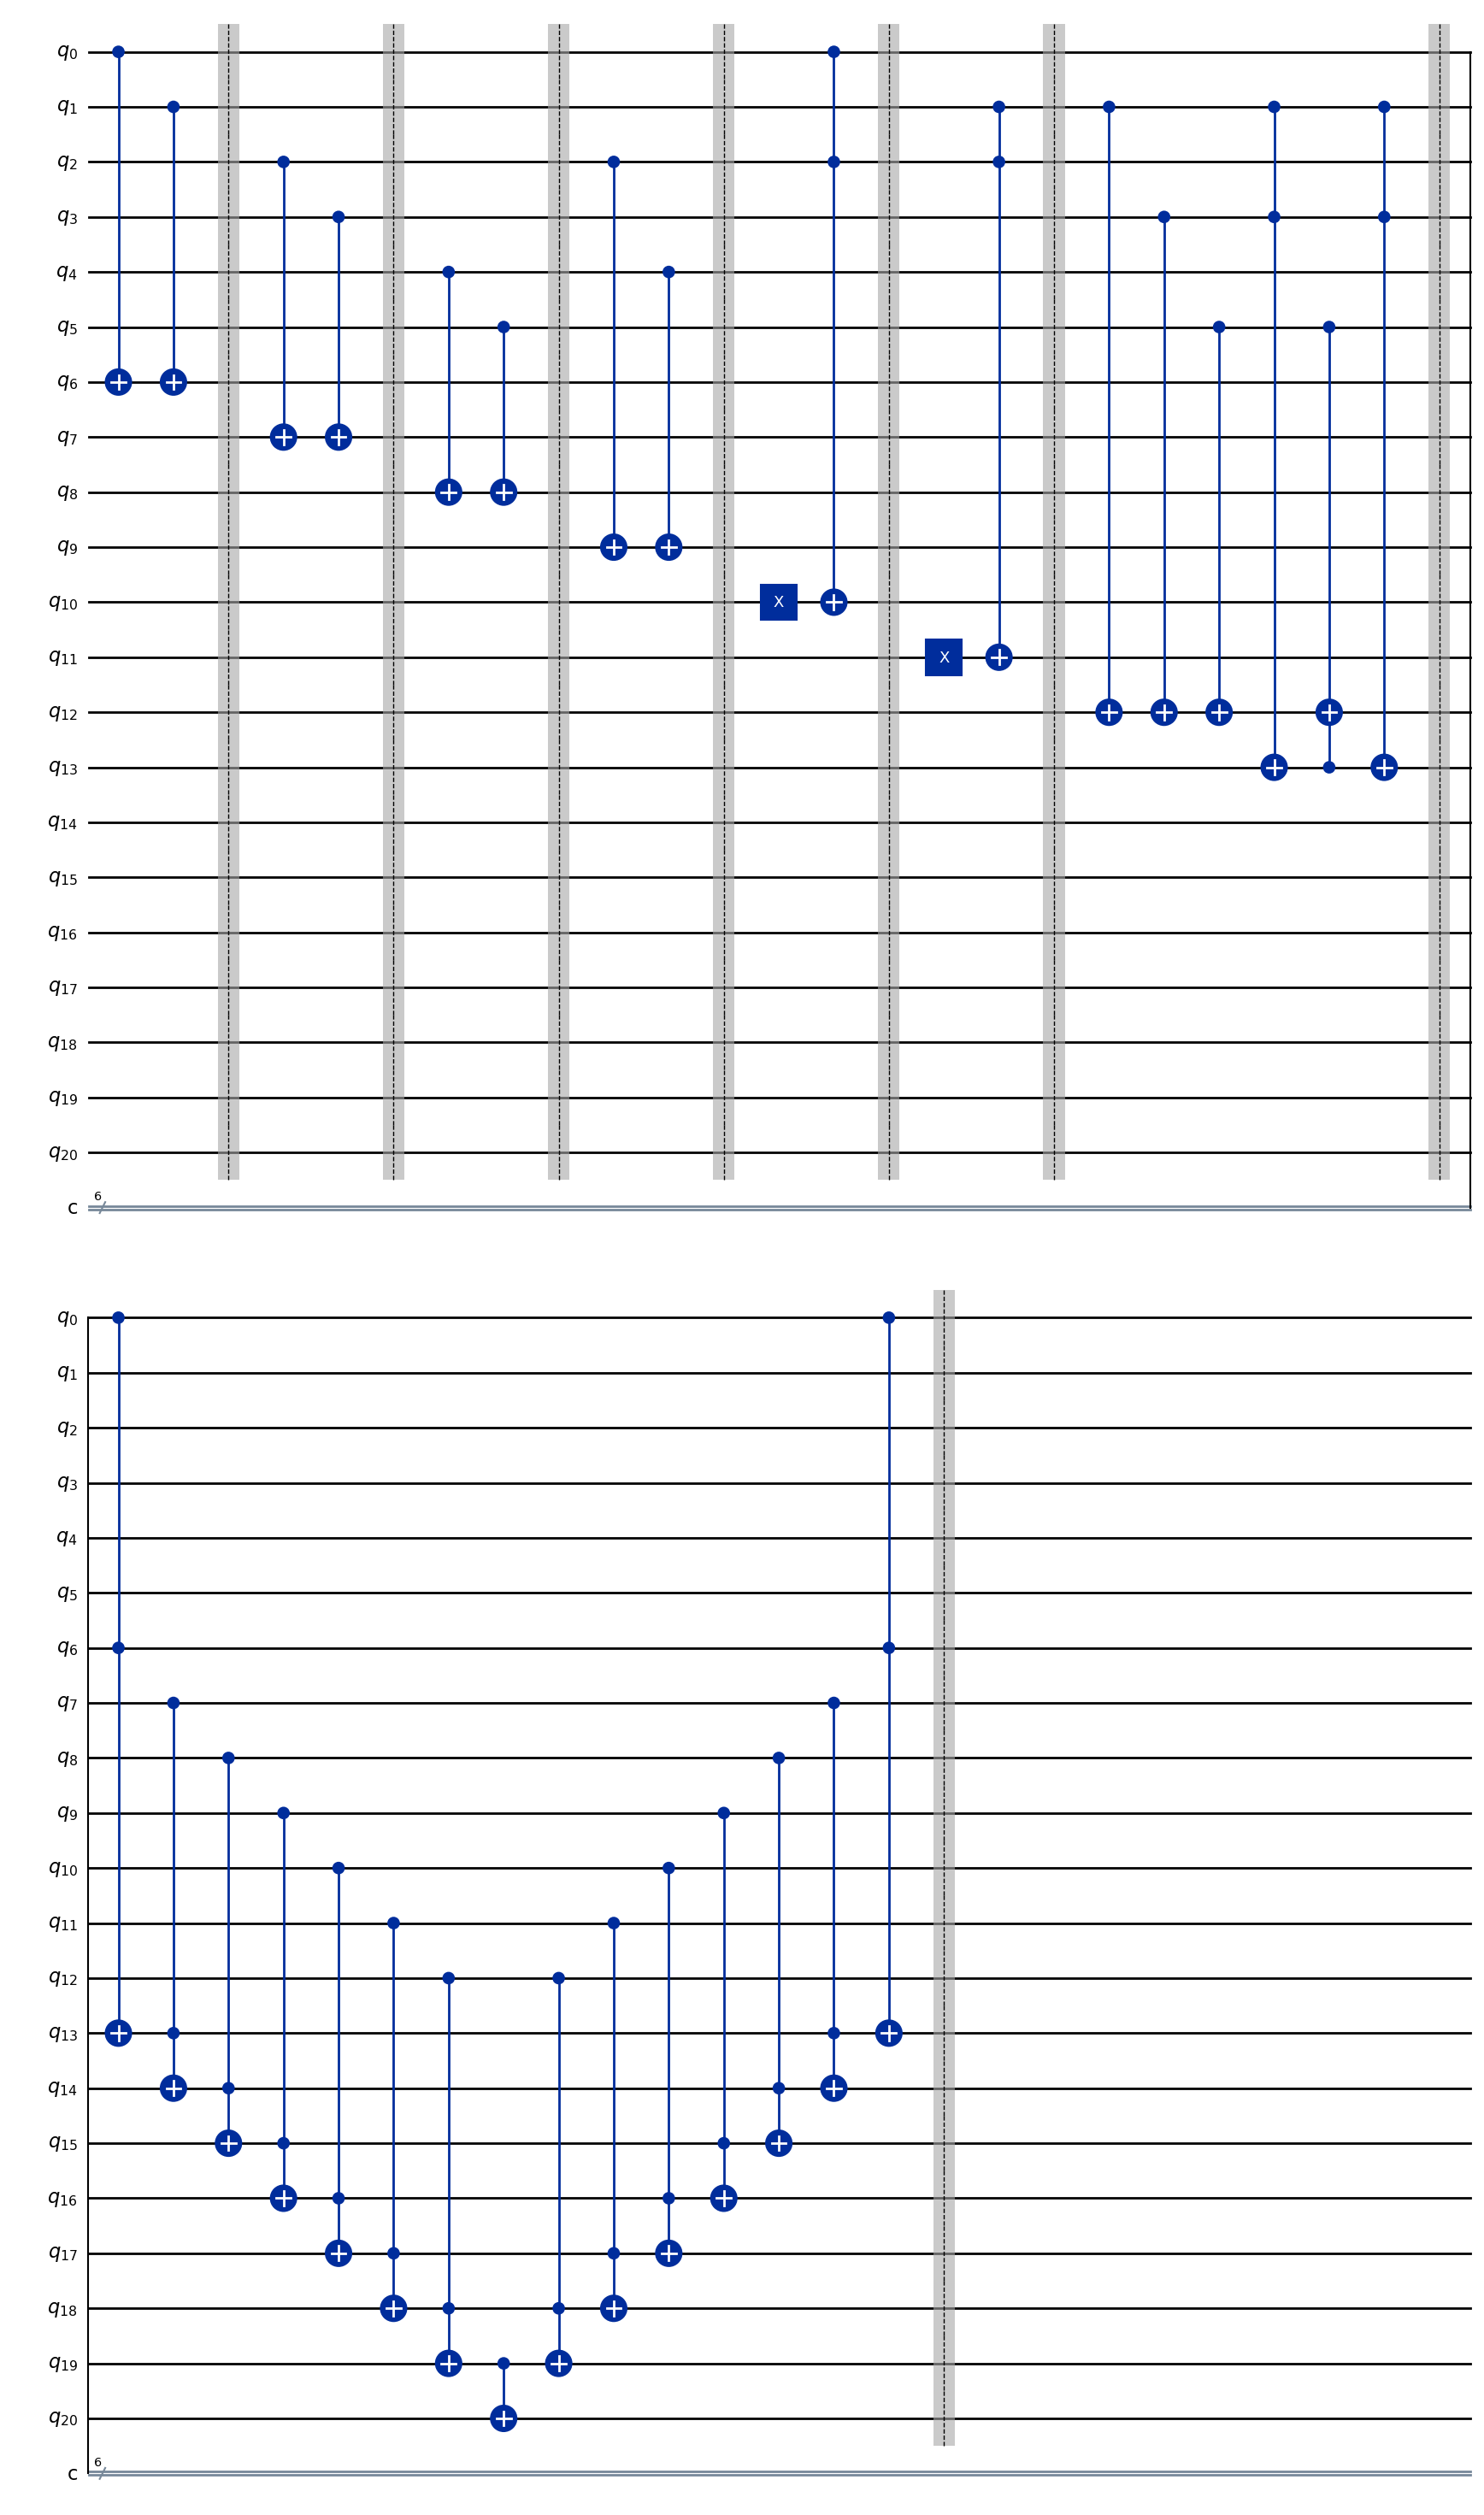

In [260]:
check_all_one(circ, qubits, ancillas, len(qub_diag_sum) + len(qub_simple_sum) + len(qub_multi_sum))
circ.draw('mpl')

In [261]:
circ.z(ancillas[7 + len(qub_diag_sum) + len(qub_simple_sum) + len(qub_multi_sum)])
circ.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=21, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(21, 'q'), 0), Qubit(QuantumRegister(21, 'q'), 1), Qubit(QuantumRegister(21, 'q'), 2), Qubit(QuantumRegister(21, 'q'), 3), Qubit(QuantumRegister(21, 'q'), 4), Qubit(QuantumRegister(21, 'q'), 5), Qubit(QuantumRegister(21, 'q'), 6), Qubit(QuantumRegister(21, 'q'), 7), Qubit(QuantumRegister(21, 'q'), 8), Qubit(QuantumRegister(21, 'q'), 9), Qubit(QuantumRegister(21, 'q'), 10), Qubit(QuantumRegister(21, 'q'), 11), Qubit(QuantumRegister(21, 'q'), 12), Qubit(QuantumRegister(21, 'q'), 13), Qubit(QuantumRegister(21, 'q'), 14), Qubit(QuantumRegister(21, 'q'), 15), Qubit(QuantumRegister(21, 'q'), 16), Qubit(QuantumRegister(21, 'q'), 17), Qubit(QuantumRegister(21, 'q'), 18), Qubit(QuantumRegister(21, 'q'), 19), Qubit(QuantumRegister(21, 'q'), 20)), clbits=())

In [262]:
# total_qubs = list(range(25))
# constraint_ancillas = [0] + list(range(6,13))

# check_all_one_optimized(
#     circ,
#     qubits,
#     constraint_ancillas,
#     ancilla_a=total_qubs[14],
#     ancilla_b=total_qubs[15],
#     phase_flip_target=total_qubs[16],
#     uncompute=False
# )
# circ.draw('mpl')


In [263]:
# OPTIMIZED UNCOMPUTE CHECK ALL ONE
# check_all_one_optimized(
#     circ,
#     qubits,
#     constraint_ancillas,
#     ancilla_a=total_qubs[14],
#     ancilla_b=total_qubs[15],
#     phase_flip_target=total_qubs[16],
#     uncompute=True
# )
# circ.draw('mpl')

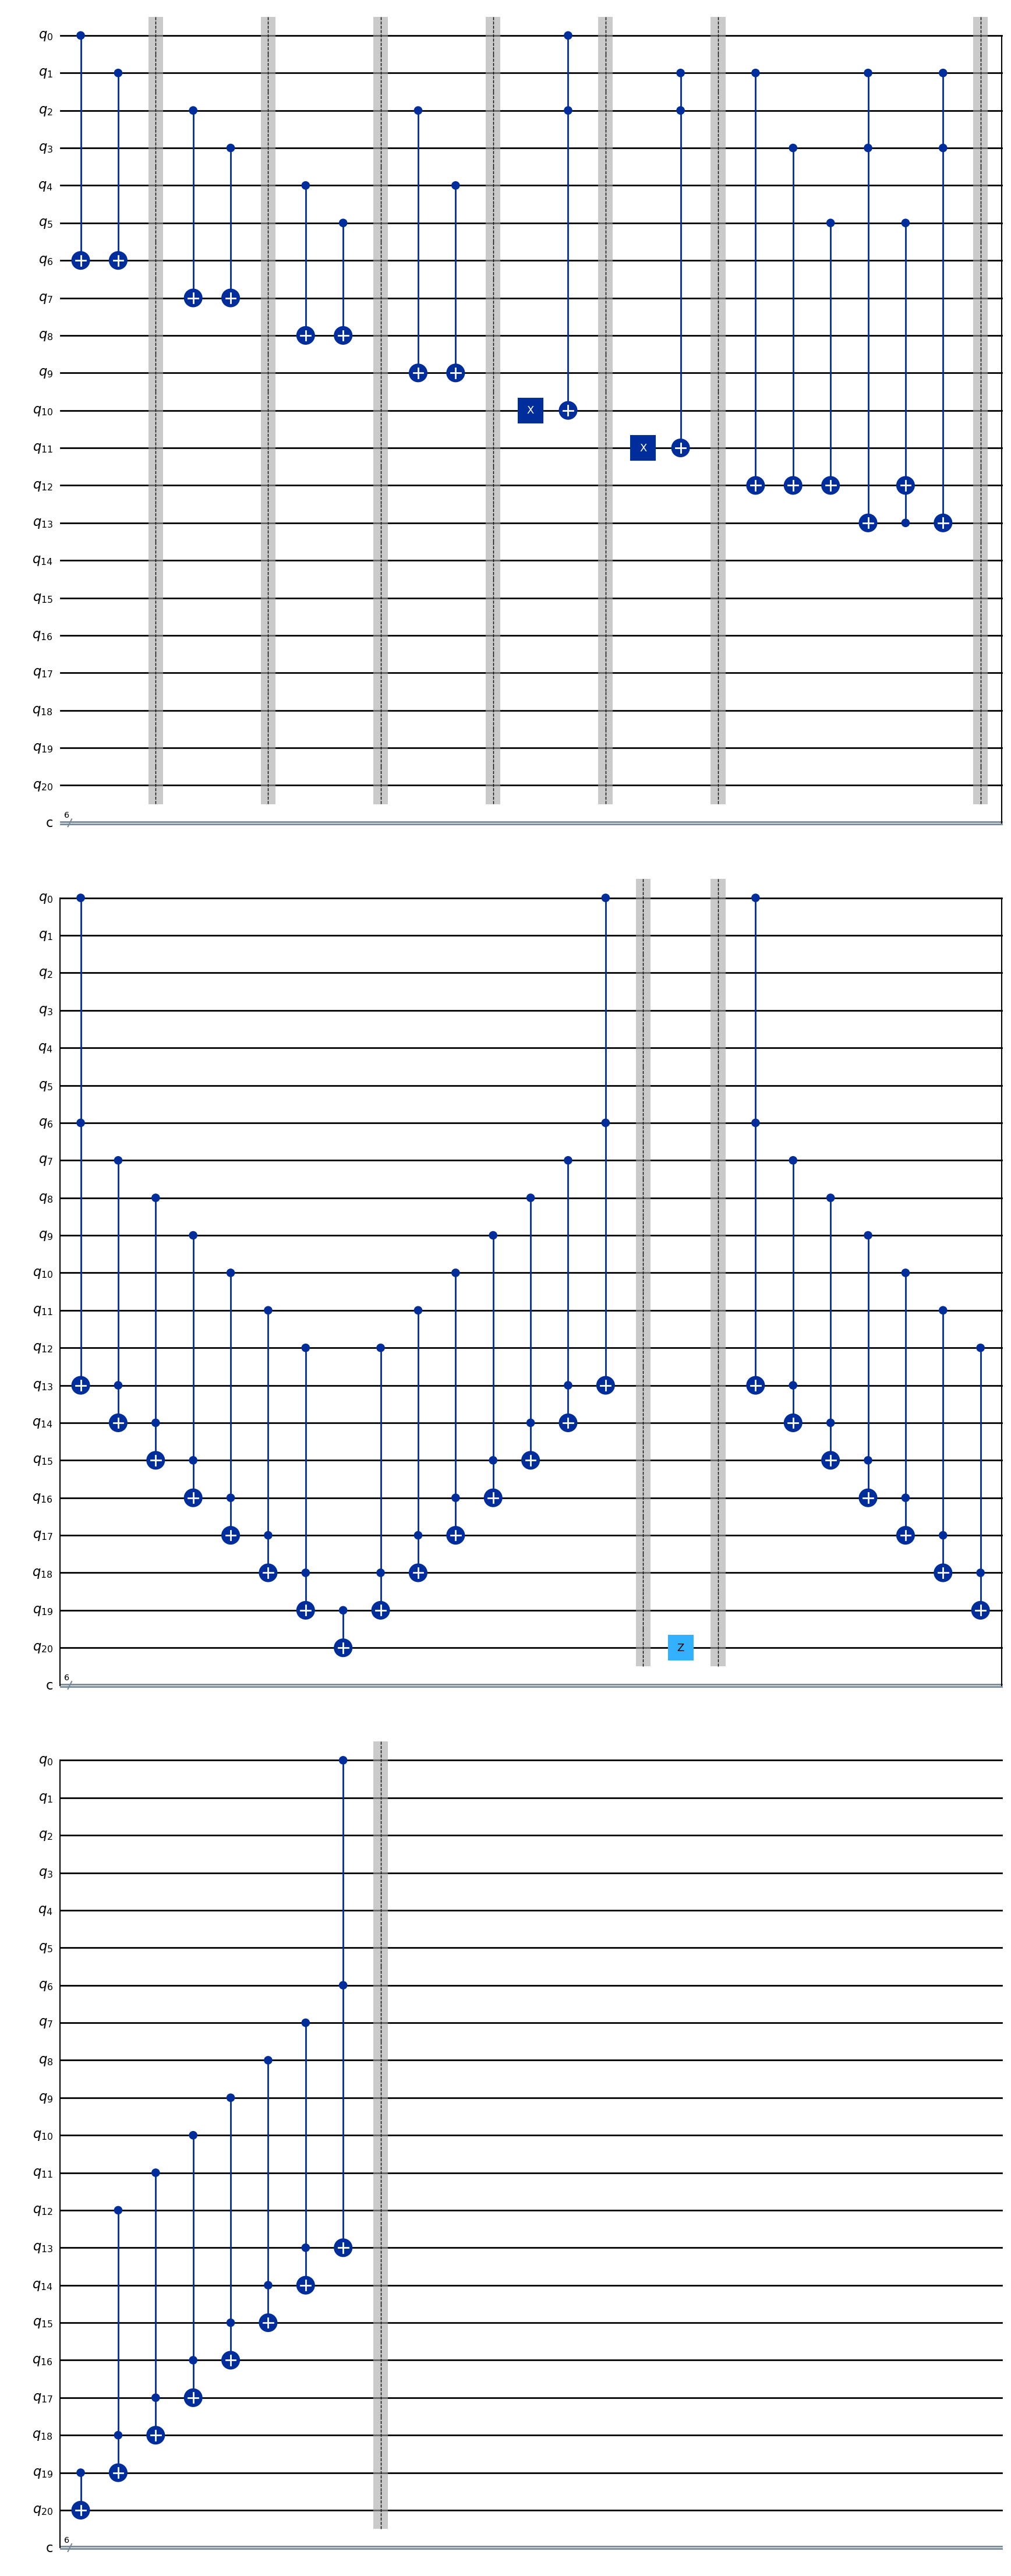

In [264]:
# REGULAR UNCOMPUTE
check_all_one(circ, qubits, ancillas, len(qub_diag_sum) + len(qub_simple_sum) + len(qub_multi_sum))
circ.draw('mpl')

In [265]:
multi_qubit_sum(circ, qub_multi_sum, ancillas, len(qub_diag_sum) + len(qub_simple_sum))
# circ.draw('mpl')

In [266]:
diagonal_constraints(circ, qub_diag_sum, ancillas, len(qub_simple_sum))
# circ.draw('mpl')

In [267]:
simple_sum(circ, qub_simple_sum, ancillas)
# circ.draw('mpl')

In [268]:
# grover_diff(circ, qubits, tot_qubs, 17)
# circ.draw('mpl')

# grover_diff(circ, qubits, tot_qubs, 21)
# circ.draw('mpl')

grover_diff_optimized(circ, qubits, ancillas)
# circ.draw('mpl')

In [269]:
# circuito = QuantumCircuit(17, 6)
# circuito = QuantumCircuit(18, 6)

circuito = QuantumCircuit(21, 6)

circuito.h(range(6))

In [270]:
# for _ in range(int(np.sqrt(2**n_qubits))):
for _ in range(8):
    circuito.compose(circ, inplace=True)

circuito.measure(range(6), range(6))

In [271]:
# circuito.draw('mpl')

In [272]:
simulator = AerSimulator()
compiled_circuit = transpile(circuito, simulator)
result = simulator.run(compiled_circuit, shots=1024).result()

In [273]:
counts = result.get_counts()
print(counts)

{'111110': 2, '011011': 2, '100100': 2, '011111': 7, '110000': 4, '000011': 7, '001101': 8, '101000': 4, '011001': 736, '011110': 3, '000000': 5, '000101': 1, '110011': 3, '001000': 7, '111101': 6, '001100': 2, '010000': 9, '100000': 3, '100110': 3, '101110': 4, '111001': 5, '001010': 1, '010100': 8, '010111': 6, '100010': 2, '111000': 5, '000010': 5, '110101': 4, '000111': 4, '101010': 7, '101100': 3, '001111': 3, '001110': 7, '000110': 3, '010001': 5, '111010': 5, '001001': 5, '010101': 10, '100001': 5, '110111': 5, '100111': 5, '000100': 6, '110001': 3, '101011': 4, '111100': 3, '010110': 4, '101101': 4, '111011': 1, '011000': 6, '001011': 5, '100101': 6, '110100': 5, '011100': 4, '110010': 5, '010011': 5, '110110': 9, '100011': 4, '111111': 1, '010010': 4, '101111': 3, '101001': 9, '000001': 4, '011010': 6, '011101': 2}


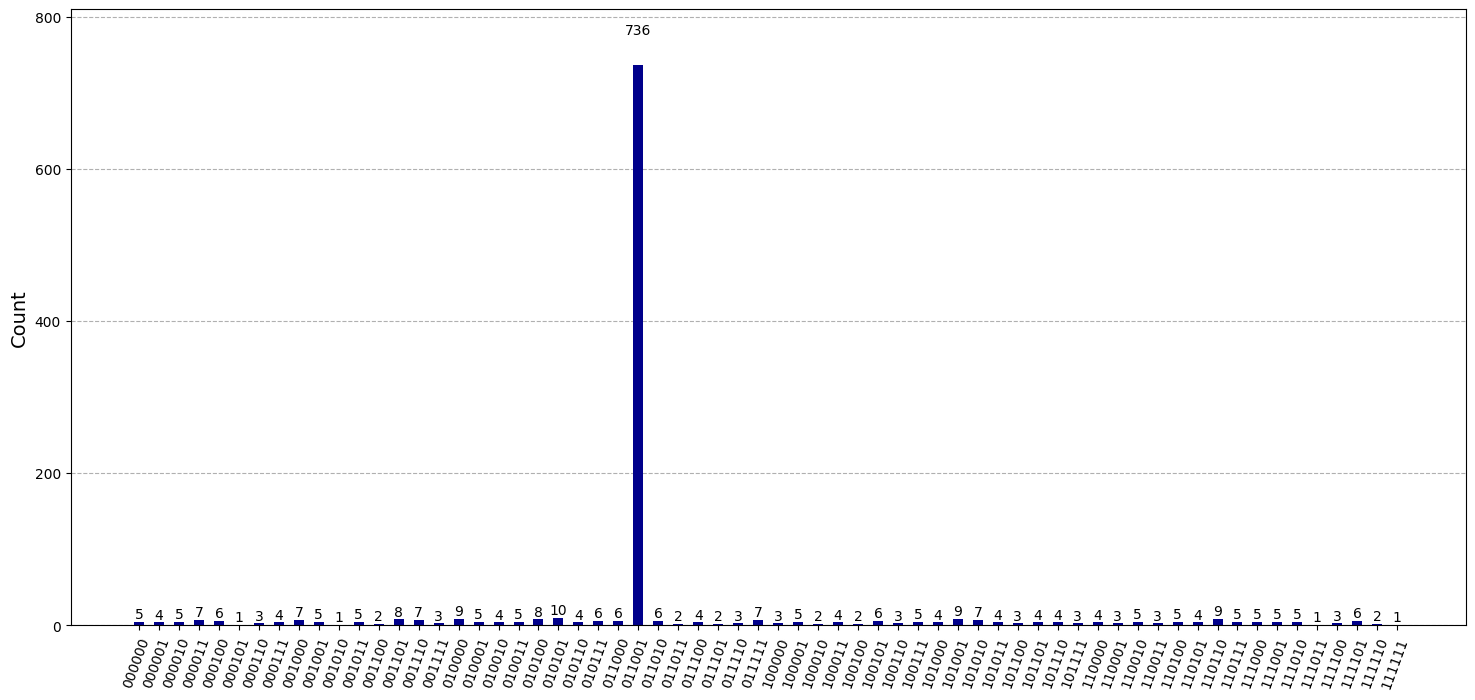

In [274]:
plot_histogram(counts, figsize=(18,8), bar_labels=True, color='darkblue')

In [275]:
def analyze_counts(counts):
    most_probable_state = max(counts, key=counts.get)
    probability = counts[most_probable_state] / sum(counts.values()) * 100
    return most_probable_state, probability

In [276]:
state, prob = analyze_counts(counts)
# state, prob = analyze_counts(filtered_counts)
print(f'The most probable state is {state} with a probability of {prob:.2f}%')

The most probable state is 011001 with a probability of 71.88%


In [277]:
valor = state

In [278]:
def plot_board(valor):
    matriz = np.zeros([4,4])
    matriz[2][0] = 1
    matriz[0][1] = valor[-1]
    matriz[0][3] = valor[-2]
    matriz[1][2] = valor[-3]
    matriz[1][3] = valor[-4]
    matriz[3][2] = valor[-5]
    matriz[3][3] = valor[-6]
    
    print(" --------------- ")
    for i in range(4):
        print("|", end = "")
        for j in range(4):
            
            if matriz[i][j] == 0:
                
                print("   |", end = "")
            else:
                print(" X |" ,end = "")
        print()
        print(" --------------- ")

In [279]:
plot_board(valor)

 --------------- 
|   | X |   |   |
 --------------- 
|   |   |   | X |
 --------------- 
| X |   |   |   |
 --------------- 
|   |   | X |   |
 --------------- 


## DANIEL'S WAY

In [ ]:
def quantum_oracle(qc, qubits, ancillas):

    # SIMPLE SUM

    #c0 + c1 = 1
    qc.cx(qubits[0], ancillas[0])
    qc.cx(qubits[1], ancillas[0])
    qc.barrier()

    #c2 + c3 = 1
    qc.cx(qubits[2], ancillas[1])
    qc.cx(qubits[3], ancillas[1])
    qc.barrier()

    #c4 + c5 = 1
    qc.cx(qubits[4], ancillas[2])
    qc.cx(qubits[5], ancillas[2])
    qc.barrier()

    #c2 + c4 = 1
    qc.cx(qubits[2], ancillas[3])
    qc.cx(qubits[4], ancillas[3])
    qc.barrier()

    #DIAGONALS

    #c0 + c2 < 2
    qc.x(ancillas[4])
    qc.cx(qubits[0], ancillas[4])
    qc.cx(qubits[2], ancillas[4])
    qc.barrier()

    #c1 + c2 < 2
    qc.x(ancillas[5])
    qc.cx(qubits[1], ancillas[5])
    qc.cx(qubits[2], ancillas[5])
    qc.barrier()

    #THREE SUM
    qc.cx(qubits[1], ancillas[6])
    qc.cx(qubits[3], ancillas[6])
    qc.cx(qubits[5], ancillas[6])
    qc.mcx([qubits[1], qubits[3]], ancillas[7])
    qc.mcx([qubits[5], ancillas[7]], ancillas[6])
    qc.mcx([qubits[1], qubits[3]], ancillas[7])

    qc.barrier()

    # CHECK ALL ONE
    qc.mcx([qubits[0], ancillas[0]], ancillas[7])
    qc.mcx([ancillas[1], ancillas[7]], ancillas[8])
    qc.mcx([ancillas[2], ancillas[8]], ancillas[9])
    qc.mcx([ancillas[3], ancillas[9]], ancillas[10])
    qc.mcx([ancillas[4], ancillas[10]], ancillas[11])
    qc.mcx([ancillas[5], ancillas[11]], ancillas[12])
    qc.mcx([ancillas[6], ancillas[12]], ancillas[13])

    #LAST SUM
    qc.cx(ancillas[13], ancillas[14])

    #RETURN CHANGES
    qc.mcx([ancillas[6], ancillas[12]], ancillas[13])
    qc.mcx([ancillas[5], ancillas[11]], ancillas[12])
    qc.mcx([ancillas[4], ancillas[10]], ancillas[11])
    qc.mcx([ancillas[3], ancillas[9]], ancillas[10])
    qc.mcx([ancillas[2], ancillas[8]], ancillas[9])
    qc.mcx([ancillas[1], ancillas[7]], ancillas[8])
    qc.mcx([qubits[0], ancillas[0]], ancillas[7])

    qc.barrier()
    qc.z(ancillas[14])
    qc.barrier()

    #UNCOMPUTE

    #RETURN CHANGES
    qc.mcx([qubits[0], ancillas[0]], ancillas[7])
    qc.mcx([ancillas[1], ancillas[7]], ancillas[8])
    qc.mcx([ancillas[2], ancillas[8]], ancillas[9])
    qc.mcx([ancillas[3], ancillas[9]], ancillas[10])
    qc.mcx([ancillas[4], ancillas[10]], ancillas[11])
    qc.mcx([ancillas[5], ancillas[11]], ancillas[12])
    qc.mcx([ancillas[6], ancillas[12]], ancillas[13])


    # qc.barrier()
    
    #LAST SUM
    qc.cx(ancillas[13], ancillas[14])

    # qc.barrier()
    
    # CHECK ALL ONE
    qc.mcx([ancillas[6], ancillas[12]], ancillas[13])
    qc.mcx([ancillas[5], ancillas[11]], ancillas[12])
    qc.mcx([ancillas[4], ancillas[10]], ancillas[11])
    qc.mcx([ancillas[3], ancillas[9]], ancillas[10])
    qc.mcx([ancillas[2], ancillas[8]], ancillas[9])
    qc.mcx([ancillas[1], ancillas[7]], ancillas[8])
    qc.mcx([qubits[0], ancillas[0]], ancillas[7])

    qc.barrier()

    #THREE SUM
    qc.mcx([qubits[1], qubits[3]], ancillas[7])
    qc.mcx([qubits[5], ancillas[7]], ancillas[6])
    qc.mcx([qubits[1], qubits[3]], ancillas[7])
    qc.cx(qubits[5], ancillas[6])
    qc.cx(qubits[3], ancillas[6])
    qc.cx(qubits[1], ancillas[6])

    qc.barrier()

    #DIAGONALS
    
    #c1 + c2 < 2
    qc.cx(qubits[2], ancillas[5])
    qc.cx(qubits[1], ancillas[5])
    qc.x(ancillas[5])

    qc.barrier()

    #c0 + c2 < 2
    qc.cx(qubits[2], ancillas[4])
    qc.cx(qubits[0], ancillas[4])
    qc.x(ancillas[4])

    qc.barrier()

    # SIMPLE SUM
    #c2 + c4 = 1
    qc.cx(qubits[4], ancillas[3])
    qc.cx(qubits[2], ancillas[3])

    qc.barrier()

    #c4 + c5 = 1
    qc.cx(qubits[5], ancillas[2])
    qc.cx(qubits[4], ancillas[2])

    qc.barrier()

    #c2 + c3 = 1
    qc.cx(qubits[3], ancillas[1])
    qc.cx(qubits[2], ancillas[0])

    qc.barrier()

    #c0 + c1 = 1
    qc.cx(qubits[1], ancillas[0])
    qc.cx(qubits[0], ancillas[0])

    qc.barrier()
    

In [ ]:
# def quantum_oracle(qc, qubits, ancillas):
#     #SIMPLE SUM

#     #c0 + c1 = 1
#     # qc.cx(qubits[0], ancillas[0])
#     # qc.cx(qubits[1], ancillas[0])
#     qc.mcx([qubits[0], qubits[1]], ancillas[0])
#     # qc.z(ancillas[0])
#     qc.barrier()

#     #c2 + c3 = 1
#     # qc.cx(qubits[2], ancillas[1])
#     # qc.cx(qubits[3], ancillas[1])
#     qc.mcx([qubits[2], qubits[3]], ancillas[1])
#     # qc.z(ancillas[1])
#     qc.barrier()
    
    
#     #c4 + c5 = 1
#     # qc.cx(qubits[4], ancillas[2])
#     # qc.cx(qubits[5], ancillas[2])
#     qc.mcx([qubits[4], qubits[5]], ancillas[2])
#     # qc.z(ancillas[2])
#     qc.barrier()
    

#     #c2 + c4 = 1
#     # qc.cx(qubits[2], ancillas[3])
#     # qc.cx(qubits[4], ancillas[3])
#     qc.mcx([qubits[4], qubits[5]], ancillas[3])
#     # qc.z(ancillas[3])
#     qc.barrier()

#     # DIAGONALS

#     #c0 + c2 < 2
#     qc.x(ancillas[4])
#     # qc.cx(qubits[0], ancillas[4])
#     # qc.cx(qubits[2], ancillas[4])
#     qc.mcx([qubits[0], qubits[2]], ancillas[4])
#     # qc.z(ancillas[4])
#     qc.barrier()

#     #c1 + c2 < 2
#     qc.x(ancillas[5])
#     # qc.cx(qubits[1], ancillas[5])
#     # qc.cx(qubits[2], ancillas[5])
#     qc.mcx([qubits[1], qubits[2]], ancillas[5])
#     # qc.z(ancillas[5])
#     qc.barrier()

#     # THREE SUM
#     qc.cx(qubits[1], ancillas[6])
#     qc.cx(qubits[3], ancillas[6])
#     qc.cx(qubits[5], ancillas[6])
#     qc.mcx([qubits[1], qubits[3]], ancillas[7])
#     qc.mcx([qubits[5], ancillas[7]], ancillas[6])
#     qc.mcx([qubits[1], qubits[3]], ancillas[7])
    
#     qc.barrier()


#     # CHECK ALL ONE
#     qc.mcx([qubits[0], ancillas[0]], ancillas[7])
#     qc.mcx([ancillas[1], ancillas[7]], ancillas[8])
#     qc.mcx([ancillas[2], ancillas[8]], ancillas[9])
#     qc.mcx([ancillas[3], ancillas[9]], ancillas[10])
#     qc.mcx([ancillas[4], ancillas[10]], ancillas[11])
#     qc.mcx([ancillas[5], ancillas[11]], ancillas[12])
#     qc.mcx([ancillas[6], ancillas[12]], ancillas[13])
#     # qc.mcx([ancillas[7], ancillas[13]], ancillas[14])
    
#     #LAST SUM
#     qc.cx(ancillas[13], ancillas[14])

#     # RETURN CHANGES
#     # qc.mcx([ancillas[7], ancillas[13]], ancillas[14])
#     qc.mcx([ancillas[6], ancillas[12]], ancillas[13])
#     qc.mcx([ancillas[5], ancillas[11]], ancillas[12])
#     qc.mcx([ancillas[4], ancillas[10]], ancillas[11])
#     qc.mcx([ancillas[3], ancillas[9]], ancillas[10])
#     qc.mcx([ancillas[2], ancillas[8]], ancillas[9])
#     qc.mcx([ancillas[1], ancillas[7]], ancillas[8])
#     qc.mcx([qubits[0], ancillas[0]], ancillas[7])
    
#     qc.barrier()
#     qc.z(ancillas[14])
#     qc.barrier()


#     #UNCOMPUTE
    
#     # CHECK ALL ONE
#     qc.mcx([qubits[0], ancillas[0]], ancillas[7])
#     qc.mcx([ancillas[1], ancillas[7]], ancillas[8])
#     qc.mcx([ancillas[2], ancillas[8]], ancillas[9])
#     qc.mcx([ancillas[3], ancillas[9]], ancillas[10])
#     qc.mcx([ancillas[4], ancillas[10]], ancillas[11])
#     qc.mcx([ancillas[5], ancillas[11]], ancillas[12])
#     qc.mcx([ancillas[6], ancillas[12]], ancillas[13])
#     # qc.mcx([ancillas[7], ancillas[13]], ancillas[14])
#     #LAST SUM
#     qc.cx(ancillas[13], ancillas[14])

#     # RETURN CHANGES
#     # qc.mcx([ancillas[7], ancillas[13]], ancillas[14])
#     qc.mcx([ancillas[6], ancillas[12]], ancillas[13])
#     qc.mcx([ancillas[5], ancillas[11]], ancillas[12])
#     qc.mcx([ancillas[4], ancillas[10]], ancillas[11])
#     qc.mcx([ancillas[3], ancillas[9]], ancillas[10])
#     qc.mcx([ancillas[2], ancillas[8]], ancillas[9])
#     qc.mcx([ancillas[1], ancillas[7]], ancillas[8])
#     qc.mcx([qubits[0], ancillas[0]], ancillas[7])
#     qc.barrier()


#     # THREE SUM
#     qc.cx(qubits[1], ancillas[6])
#     qc.cx(qubits[3], ancillas[6])
#     qc.cx(qubits[5], ancillas[6])
#     qc.mcx([qubits[1], qubits[3]], ancillas[7])
#     qc.mcx([qubits[5], ancillas[7]], ancillas[6])
#     qc.mcx([qubits[1], qubits[3]], ancillas[7])
    
#     qc.barrier()

#     # DIAGONALS

#     #c0 + c2 < 2
#     qc.x(ancillas[4])
#     # qc.cx(qubits[0], ancillas[4])
#     # qc.cx(qubits[2], ancillas[4])
#     qc.mcx([qubits[0], qubits[2]], ancillas[4])
#     # qc.z(ancillas[4])
#     qc.barrier()
    
#     #c1 + c2 < 2
#     qc.x(ancillas[5])
#     # qc.cx(qubits[1], ancillas[5])
#     # qc.cx(qubits[2], ancillas[5])
#     qc.mcx([qubits[1], qubits[2]], ancillas[5])
#     # qc.z(ancillas[5])
#     qc.barrier()

#     #SIMPLE SUM

#     #c0 + c1 = 1
#     # qc.cx(qubits[0], ancillas[0])
#     # qc.cx(qubits[1], ancillas[0])
#     qc.mcx([qubits[0], qubits[1]], ancillas[0])
#     # qc.z(ancillas[0])
#     qc.barrier()


#     #c2 + c3 = 1
#     # qc.cx(qubits[2], ancillas[1])
#     # qc.cx(qubits[3], ancillas[1])
#     qc.mcx([qubits[2], qubits[3]], ancillas[1])
#     # qc.z(ancillas[1])
#     qc.barrier()

#     #c4 + c5 = 1
#     # qc.cx(qubits[4], ancillas[2])
#     # qc.cx(qubits[5], ancillas[2])
#     qc.mcx([qubits[4], qubits[5]], ancillas[2])
#     # qc.z(ancillas[2])
#     qc.barrier()
    
#     #c2 + c4 = 1
#     # qc.cx(qubits[2], ancillas[3])
#     # qc.cx(qubits[4], ancillas[3])
#     qc.mcx([qubits[2], qubits[4]], ancillas[3])
#     # qc.z(ancillas[3])
#     qc.barrier()

In [ ]:
# def quantum_oracle(qc, qubits, ancillas):
#     #ROW TWO QUBIT CONTRAINTS

#     #c0 + c1 = 1
#     qc.mcx([qubits[0], qubits[1]], ancillas[0])
#     qc.z(ancillas[0])
#     # qc.barrier()

#     #c2 + c3 = 1
#     qc.mcx([qubits[2], qubits[3]], ancillas[1])
#     qc.z(ancillas[1])
#     # qc.barrier()

#     #c4 + c5 = 1
#     qc.mcx([qubits[4], qubits[5]], ancillas[2])
#     qc.z(ancillas[2])
#     # qc.barrier()


#     #COLUMN TWO QUBIT CONSTRAINTS

#     # we don't check c0 since it is fixed
#     qc.x(qubits[0])
#     # qc.x(qubits[0])
#     # qc.barrier()

#     #c2 + c4 = 1
#     qc.mcx([qubits[2], qubits[4]], ancillas[3])
#     qc.z(ancillas[3])
#     # qc.mcx([qubits[2], qubits[4]], ancillas[3])
#     # qc.barrier()
    
#     #DIAGONAL TWO QUBIT CONSTRAINTS

#     # c0 + c2 < 2
#     qc.x(ancillas[4])
#     qc.mcx([qubits[0], qubits[2]], ancillas[4])
#     qc.z(ancillas[4])
#     # qc.mcx([qubits[0], qubits[2]], ancillas[4]) #uncomputation needed
#     # qc.barrier()
    
#     # c1 + c2 < 2
#     qc.x(ancillas[5])
#     qc.mcx([qubits[1], qubits[2]], ancillas[5])
#     qc.z(ancillas[5])
#     # qc.mcx([qubits[1], qubits[2]], ancillas[5]) #uncomputation needed
#     # qc.barrier()

#     #THREE QUBIT COLUMN CONSTRAINT

#     #c1 + c3 + c5 = 1
#     qc.mcx([qubits[1], qubits[3]], ancillas[7]) # store c1 and c3 in ancilla[7]
#     qc.mcx([ancillas[7], qubits[5]], ancillas[6]) # store previous result and c5 in ancilla[6]

#     qc.z(ancillas[6])# flip phase if multiple queens are present
#     # qc.barrier()

#     #UNCOMPUTATION
    
#     # c1 + c3 + c5 = 1 uncompute
#     qc.mcx([ancillas[7], qubits[5]], ancillas[6])
#     qc.mcx([qubits[1], qubits[3]], ancillas[7])
#     # qc.barrier()

#     # c1 + c2 < 2 uncompute
#     qc.mcx([qubits[1], qubits[2]], ancillas[5])
#     qc.x(ancillas[5])
#     # qc.barrier()

#     # c0 + c2 < 2 uncompute
#     qc.mcx([qubits[0], qubits[2]], ancillas[4])
#     qc.x(ancillas[4]) 
#     # qc.barrier()
    
#     #c2 + c4 = 1 uncompute
#     qc.mcx([qubits[2], qubits[4]], ancillas[3])
#     # qc.barrier()

#     # c0 = 1 uncompute
#     qc.x(qubits[0])
#     # qc.barrier()
    
#     #c4 + c5 = 1 uncompute
#     qc.mcx([qubits[4], qubits[5]], ancillas[2])
#     # qc.barrier()
    
#     #c2 + c3 = 1 uncompute
#     qc.mcx([qubits[2], qubits[3]], ancillas[1])
#     # qc.barrier()
    
#     #c0 + c1 = 1 uncompute
#     qc.mcx([qubits[0], qubits[1]], ancillas[0])
#     # qc.barrier()
    

In [ ]:
def grover_diffusion(qc, qubits, ancillas):
    qc.h(qubits)
    qc.x(qubits)
    qc.barrier()

    #Equivalent of MCZ gate, Hadamard gates and MCX gate
    
    # qc.h(ancillas[15])
    # qc.mcx(qubits, ancillas[15])
    # qc.h(ancillas[15])

    qc.mcx([qubits[0], qubits[1]], ancillas[15])
    qc.mcx([qubits[2], ancillas[15]], ancillas[16])
    qc.mcx([qubits[3], ancillas[16]], ancillas[17])
    qc.mcx([qubits[4], ancillas[17]], ancillas[18])
    qc.barrier()
    qc.cz(qubits[5], ancillas[19])
    qc.barrier()
    qc.mcx([qubits[4], ancillas[17]], ancillas[18])
    qc.mcx([qubits[3], ancillas[16]], ancillas[17])
    qc.mcx([qubits[2], ancillas[15]], ancillas[16])
    qc.mcx([qubits[0], qubits[1]], ancillas[15])
    
    qc.barrier()

    qc.x(qubits)
    qc.h(qubits)
    qc.barrier()

In [ ]:
def queens_grover(n_ancillas=8, n_qubits=6, num_iterations=1):
    qc = QuantumCircuit(n_qubits + n_ancillas, n_qubits)

    qubits = list(range(n_qubits))
    ancillas = list(range(n_qubits, n_qubits + n_ancillas))

    initialize_superposition(qc, qubits)

    for _ in range(num_iterations):
        quantum_oracle(qc, qubits, ancillas)
        grover_diffusion(qc, qubits, ancillas)

    qc.measure(range(n_qubits), range(n_qubits))
    return qc

In [ ]:
n_qubits = 6
n_ancillas = 20

qc = QuantumCircuit(n_qubits + n_ancillas, n_qubits)

qubits = list(range(n_qubits))
ancillas = list(range(n_qubits, n_qubits + n_ancillas))

initialize_superposition(qc, qubits)

quantum_oracle(qc, qubits, ancillas)
grover_diffusion(qc, qubits, ancillas)

qc.measure(range(n_qubits), range(n_qubits))

qc.draw(output='mpl', style={'backgroundcolor': '#F0F0F0'})

In [ ]:
# fixed queen value for a 4x4 in board position (2,0)
# fixed_queen = 8

n_qubits = 6
n_ancillas = 20

qc = QuantumCircuit(n_qubits + n_ancillas, n_qubits)

qubits = list(range(n_qubits))
ancillas = list(range(n_qubits, n_qubits + n_ancillas))

initialize_superposition(qc, qubits)

for _ in range(int(np.sqrt(2**(n_qubits)))):        
    quantum_oracle(qc, qubits, ancillas)
    grover_diffusion(qc, qubits, ancillas)

qc.measure(range(n_qubits), range(n_qubits))

In [ ]:
simulator = AerSimulator()
# compiled_circuit = transpile(grover_circuit, simulator)
compiled_circuit = transpile(qc, simulator)
result = simulator.run(compiled_circuit, shots=1024).result()
counts = result.get_counts()
plot_histogram(counts, figsize=(14,8), bar_labels=True, color='darkblue')
# plot_histogram(counts)

In [ ]:
def analyze_counts(counts):
    most_probable_state = max(counts, key=counts.get)
    probability = counts[most_probable_state] / sum(counts.values()) * 100
    return most_probable_state, probability

In [ ]:
state, prob = analyze_counts(counts)
# state, prob = analyze_counts(filtered_counts)
print(f'The most probable state is {state} with a probability of {prob:.2f}%')

In [ ]:
valor = state

In [ ]:
def plot_board(valor):
    matriz = np.zeros([4,4])
    matriz[2][0] = 1
    matriz[0][1] = valor[-1]
    matriz[0][3] = valor[-2]
    matriz[1][2] = valor[-3]
    matriz[1][3] = valor[-4]
    matriz[3][2] = valor[-5]
    matriz[3][3] = valor[-6]
    
    print(" --------------- ")
    for i in range(4):
        print("|", end = "")
        for j in range(4):
            
            if matriz[i][j] == 0:
                
                print("   |", end = "")
            else:
                print(" X |" ,end = "")
        print()
        print(" --------------- ")

In [ ]:
plot_board(valor)

In [ ]:
def initialize_superposition(qc, qubits):
    for qubit in qubits:
        qc.h(qubit)

In [ ]:
def row_constraint(qc, qubits, ancilla):
    for i in range(len(qubits)):
        for j in range(i+1, len(qubits)):
            qc.mcx([qubits[i], qubits[j]], ancilla)
            qc.z(ancilla)
            qc.mcx([qubits[i], qubits[j]], ancilla)
            # print(f'checking row constraint between qubit {i} and qubit {j}')

In [ ]:
def col_constraint(qc, qubits, ancilla):
    for i in range(len(qubits)):
        for j in range(i+1, len(qubits)):
            qc.mcx([qubits[i], qubits[j]], ancilla)
            qc.z(ancilla)
            qc.mcx([qubits[i], qubits[j]], ancilla)
            # print(f'checking column constraint between qubit {i} and qubit {j}')

In [ ]:
def diagonal_constraint(qc, qubits, ancilla):
    for i in range(len(qubits)):
        for j in range(i+1, len(qubits)):
            if abs(i - j) == abs(qubits[i] - qubits[j]):
                qc.mcx([qubits[i], qubits[j]], ancilla)
                qc.z(ancilla)
                qc.mcx([qubits[i], qubits[j]], ancilla)
                # print(f'checking for diagonal constraint between qubit {i} and qubit {j}')

In [ ]:
def grover_diffusion(qc, qubits):
    qubit_list = list(qubits)
    
    qc.h(qubit_list) # apply hadamard gates
    qc.x(qubit_list) # apply x gates (inversion)
    qc.h(qubit_list[-1]) #hadamard on last qubit
    qc.mcx(qubit_list[:-1], qubit_list[-1]) #multi controlled not
    qc.h(qubit_list[-1])
    qc.x(qubit_list)
    qc.h(qubit_list)

In [ ]:
def n_queens_grover(n=4):
    num_qubits = n
    qc = QuantumCircuit(num_qubits + 1, num_qubits) # extra ancilla qubit

    # create superposition of all board states
    initialize_superposition(qc, range(num_qubits))

    #apply constraints
    ancilla = num_qubits
    row_constraint(qc, range(num_qubits), ancilla)
    col_constraint(qc, range(num_qubits), ancilla)
    diagonal_constraint(qc, range(num_qubits), ancilla)

    #apply grover's diffusion operator
    grover_diffusion(qc, range(num_qubits))

    #measure
    qc.measure(range(num_qubits), range(num_qubits))

    return qc

In [ ]:
grover_circuit = n_queens_grover()
simulator = AerSimulator()
compiled_circuit = transpile(grover_circuit, simulator)
result = simulator.run(compiled_circuit, shots=5000).result()
counts = result.get_counts()
plot_histogram(counts)

In [ ]:
def is_valid_n_queens_solution(binary_string):
    n = len(binary_string)
    queen_positions = []

    for row, char in enumerate(binary_string):
        if char == '1':
            queen_positions.append(row)

    if len(queen_positions) != n:
        return False

    if len(set(queen_positions)) != n:
        return False

    for i in range(n):
        for j in range(i+1, n):
            if abs(i - j) == abs(queen_positions[i] - queen_positions[j]):
                return False

    return True

In [ ]:
from qiskit.quantum_info import Statevector

In [ ]:
def test_oracle_v2(n=4):
    qc = QuantumCircuit(n+1)
    qubits = list(range(n))
    ancilla = n

    for qubit in qubits:
        qc.h(qubit)

    oracle_v2(qc, qubits, ancilla)

    simulator = AerSimulator(method='statevector')
    compiled_circuit = transpile(qc, simulator)
    job = simulator.run(compiled_circuit)
    result = job.result()

    statevector = Statevector(qc)
    print(f'statevector after fixed oracle: {statevector}')
    statevector.draw(output='hinton')

In [ ]:
test_oracle_v2()

In [ ]:
# Example usage:
print(is_valid_n_queens_solution("0010")) 
print(is_valid_n_queens_solution("0000"))
print(is_valid_n_queens_solution("0100"))

## PENNYLANE

## GROVER NOTES